<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>2021 Semester 1, Group 140</h2>

Submitted by:<br>
cdry8676 	309258162<br>
clee9121 	500240508<br>
 vphr4117 	500375442<br>
cqia2144 	480013758<br>
zwan9258 	500226443<br>

# Importing Packages

In [1]:
#conda install -c conda-forge geopy

In [2]:
#conda install -c conda-forge cartopy

In [3]:
#pip install yellowbrick

In [4]:
#pip install regressors

In [5]:
#pip install xgboost

In [6]:
import time
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import xgboost as xgb
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from scipy import stats
from regressors import stats
from sklearn.manifold import TSNE
from geopy.geocoders import Nominatim
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.regressor import AlphaSelection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, scale
from statlearning import plot_feature_importance, plot_coefficients
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, RepeatedKFold, cross_val_score, cross_validate, cross_val_predict


from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statlearning import plot_feature_importance
from scipy import stats
import xgboost as xgb

warnings.filterwarnings("ignore")

# Loading Data 

In [7]:
# Read in csv files and plot top of training data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Id,price,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,2000,199,within an hour,1.00,1.00,t,5,f,-33.918732,151.242035,...,10.0,9.0,10.0,10.0,10.0,t,flexible,f,f,0.23
1,2001,95,NaN,NaN,0.83,t,1,f,-33.698425,151.290979,...,10.0,10.0,10.0,10.0,10.0,t,moderate,f,f,0.83
2,2002,156,within an hour,0.91,0.98,f,8,f,-33.847388,151.072890,...,9.0,10.0,10.0,10.0,9.0,f,strict_14_with_grace_period,f,f,6.90
3,2003,100,within an hour,0.99,0.97,f,260,f,-33.870261,151.195131,...,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,f,f,1.32
4,2004,100,within a day,1.00,NaN,f,1,f,-33.908168,151.211849,...,NaN,NaN,NaN,NaN,NaN,f,moderate,f,f,0.07


In [8]:
# Get dimensions of the data
dim_train = np.shape(train)
print("Training data dimensions", dim_train)

# Note we have one less dimension in testing data as there is no response variable
dim_test = np.shape(test)
print("Testing data dimensions", dim_test) 

Training data dimensions (2000, 36)
Testing data dimensions (2000, 35)


In [9]:
#Examine the missingness of the training data
train.isna().sum()

Id                                    0
price                                 0
host_response_time                  935
host_response_rate                  935
host_acceptance_rate                713
host_is_superhost                     0
host_listings_count                   0
host_identity_verified                0
latitude                              0
longitude                             0
property_type                         0
room_type                             0
accommodates                          0
bathrooms                             0
bedrooms                              2
beds                                 12
bed_type                              0
security_deposit                    707
cleaning_fee                        523
guests_included                       0
extra_people                          0
minimum_nights                        0
maximum_nights                        0
number_of_reviews                     0
review_scores_rating                491


In [10]:
# Examine missingness of the testing data
test.isna().sum()

Id                                    0
host_response_time                  976
host_response_rate                  976
host_acceptance_rate                718
host_is_superhost                     0
host_listings_count                   0
host_identity_verified                0
latitude                              0
longitude                             0
property_type                         0
room_type                             0
accommodates                          0
bathrooms                             0
bedrooms                              4
beds                                  3
bed_type                              0
security_deposit                    670
cleaning_fee                        501
guests_included                       0
extra_people                          0
minimum_nights                        0
maximum_nights                        0
number_of_reviews                     0
review_scores_rating                484
review_scores_accuracy              486


In [11]:
# Deal with missing data by filling NA with a 0 value
nacolsfill0 = ["bedrooms", "beds", "cleaning_fee", "security_deposit", "host_response_time"]

for i in nacolsfill0:
    train[i].fillna(0, inplace=True)
    test[i].fillna(0, inplace=True)
   
#For all other columns fill with the mean
natraincolsfillmean = train.columns[train.isnull().any()].tolist() 
natestcolsfillmean = test.columns[test.isnull().any()].tolist()

#For all other remaining columns with na values, fill with the mean.
for i in natraincolsfillmean:
    train[i].fillna(np.mean(train[i]), inplace=True)
    
for i in natestcolsfillmean:
    test[i].fillna(np.mean(test[i]), inplace=True)

In [12]:
# Examine missingness of the testing data
train.isna().sum()

Id                                  0
price                               0
host_response_time                  0
host_response_rate                  0
host_acceptance_rate                0
host_is_superhost                   0
host_listings_count                 0
host_identity_verified              0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating                0
review_scores_accuracy              0
review_score

In [13]:
# Examine missingness of the testing data
test.isna().sum()

Id                                  0
host_response_time                  0
host_response_rate                  0
host_acceptance_rate                0
host_is_superhost                   0
host_listings_count                 0
host_identity_verified              0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating                0
review_scores_accuracy              0
review_scores_cleanliness           0
review_score

In [14]:
# Check different sub-classes from each variable. The pandas' crosstab feature allows us to plot the frequency of sub-groups
for i in train.columns.values.tolist():
    pd.crosstab(index=train[i], columns="count")

pd.crosstab(index=train['property_type'], columns="count")

col_0,count
property_type,
Apartment,1327
Bed and breakfast,2
Boat,2
Boutique hotel,10
Bungalow,6
Cabin,6
Camper/RV,1
Condominium,34
Cottage,7


In [15]:
# Encode smaller number of categorical variables for property type
train['property_type_encoded'] = np.where(train['property_type'].str.contains('House'), "House", (np.where(train['property_type'].str.contains('Apartment'), "Apartment", (np.where(train['property_type'].str.contains('Townhouse'), "Townhouse", "Other")))))
test['property_type_encoded'] = np.where(test['property_type'].str.contains('House'), "House", (np.where(test['property_type'].str.contains('Apartment'), "Apartment", (np.where(test['property_type'].str.contains('Townhouse'), "Townhouse", "Other")))))

# Count frequency of different categories after sorting to smaller number of categories
pd.crosstab(index=train["property_type_encoded"], columns="count")

train = train.drop('property_type', 1)
test = test.drop('property_type', 1)

In [16]:
latitude = 'latitude'
longitude = 'longitude'

train_lat = train[latitude]
train_long = train[longitude]
test_lat = test[latitude]
test_long = test[longitude]

[]

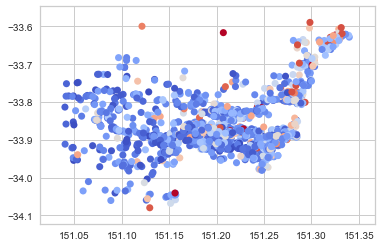

In [17]:
# Use the map to see the distributions of the train data 

cmap = sns.diverging_palette(200,15,as_cmap = True)
plt.scatter(train_long,train_lat,s=50, c=train['price'],edgecolors = 'none',
            cmap = plt.get_cmap('coolwarm'),alpha = 1)
plt.plot()

[]

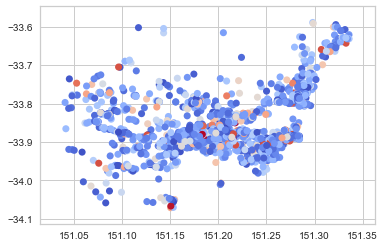

In [18]:
# Use the map to see the distributions of the test data 

cmap = sns.diverging_palette(200,15,as_cmap = True)
plt.scatter(test_long,test_lat,s=50, c=train['price'],edgecolors = 'none',
            cmap = plt.get_cmap('coolwarm'),alpha = 1)
plt.plot()

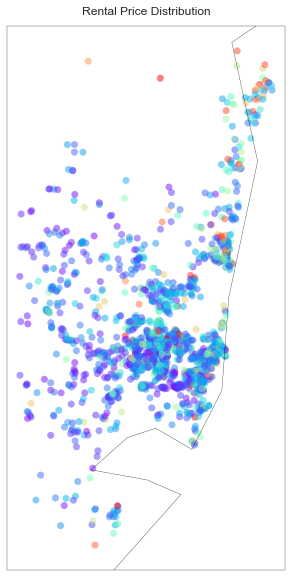

In [19]:
# Latitude and longitude for the edges of the map
# Latitudes and Longitude of NSW, Australia
#lat1, lat2, lon1, lon2= -38.0000, -30.0000, 142.0000, 152.0000

# Create figures
#Warmer colours indicate higher prices,
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mercator())

# Get latitude and longitude for each data point
x, y = (train_long.to_numpy(), train_lat.to_numpy())

# Scatter plot as heat map

ax.scatter(x,y, c=train['price'].to_numpy(), 
           edgecolors='none', cmap=plt.get_cmap('rainbow'),\
           alpha=0.5, transform=ccrs.PlateCarree())


# # Add state borders and coast line
#ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))

#ax.set_extent([-38.0000, -30.0000, 140.0000, 154.0000], crs=ccrs.PlateCarree())
ax.set_title('Rental Price Distribution', y=1.01)

plt.show()

In [20]:
#convert latitude and longitude into strings for train data
dumm1=train_lat.map(str)
dumm2=train_long.map(str)
dumm3=dumm1+","+dumm2

print(dumm3.head())

0           -33.91873218,151.2420354
1           -33.69842536,151.2909795
2    -33.847387899999994,151.0728898
3           -33.87026105,151.1951312
4           -33.90816791,151.2118495
dtype: object


In [21]:
#convert latitude and longitude into strings for test data
dumm4=test_lat.map(str)
dumm5=test_long.map(str)
dumm6=dumm4+","+dumm5

print(dumm6.head())

0    -33.77668039,151.26174019999996
1    -33.79569445,151.15596399999998
2           -33.87464053,151.2252483
3    -33.89819836,151.17827739999998
4    -34.04478615,151.14560590000002
dtype: object


In [24]:
# initialize Nominatim API
geolocator = Nominatim(user_agent="Cait")

In [25]:
#Get address of each pair of latitude and longitude for train data
address = [geolocator.reverse(latlon).raw['address'] for latlon in dumm3]

In [26]:
#Get address of each pair of latitude and longitude for test data
addresstest = [geolocator.reverse(latlon).raw['address'] for latlon in dumm6]

In [27]:
dumpostcode=[]
for i in np.arange(0, len(train)):
    dumpostcode.append(address[i]['postcode'])
            
print(len(dumpostcode))    

2000


In [28]:
dumpostcodetest=[]
for i in np.arange(0, len(test)):
    dumpostcodetest.append(address[i]['postcode'])
            
print(len(dumpostcodetest))  

2000


In [29]:
train['Postcode'] = dumpostcode
train['Postcode'].head()

0    2031
1    2101
2    2127
3    2009
4    2017
Name: Postcode, dtype: object

In [30]:
test['Postcode'] = dumpostcodetest
test['Postcode'].head()

0    2031
1    2101
2    2127
3    2009
4    2017
Name: Postcode, dtype: object

In [31]:
np.shape(train)

(2000, 37)

In [32]:
np.shape(test)

(2000, 36)

In [33]:
type(train['latitude'][0])

numpy.float64

In [34]:
type(train['Postcode'][0])

str

In [35]:
train['Postcode'] = pd.to_numeric(train['Postcode'], downcast="float")
test['Postcode'] = pd.to_numeric(test['Postcode'], downcast="float")

In [36]:
#Create interaction terms for postcode and latitude, postcode and longitude
train['latitude_postcode'] = train['Postcode'] * train['latitude']
test['latitude_postcode'] = test['Postcode'] * test['latitude']
train['longitude_postcode'] = train['Postcode'] * train['longitude']
test['longitude_postcode'] = test['Postcode'] * test['longitude']

In [37]:
#Save the postcode processed files
train.to_csv('Train_with_postcode.csv')
test.to_csv('Test_with_postcode.csv')

In [38]:
# Import the postcode processed files 
train = pd.read_csv("train_with_postcode.csv")
test = pd.read_csv("test_with_postcode.csv")

In [39]:
train = train.drop(['Unnamed: 0'], axis = 1)
test = test.drop(['Unnamed: 0'], axis = 1)

# Exploratory Data Analysis

## Setting Dummy Variables

In [40]:
set(train.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [41]:
#select all features that are objects and will need to be made into dummy variables
set(train.select_dtypes(include=[object]))

{'bed_type',
 'cancellation_policy',
 'host_identity_verified',
 'host_is_superhost',
 'host_response_time',
 'instant_bookable',
 'property_type_encoded',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'room_type'}

In [42]:
#Save the test dataset and create new dataset with dummies.
test_with_dummies = test

for i in set(test.select_dtypes(include=[object])):
    test_with_dummies = pd.get_dummies(test_with_dummies, prefix=str(i+'_'), columns=[i])

test_with_dummies.head()

,Id,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,instant_bookable__f,instant_bookable__t,bed_type__Couch,bed_type__Futon,bed_type__Pull-out Sofa,bed_type__Real Bed,require_guest_phone_verification__f,require_guest_phone_verification__t,host_identity_verified__f,host_identity_verified__t
0,0,1.000000,0.570000,1,-33.776680,151.261740,1,1.0,1.0,1.0,...,1,0,0,0,0,1,1,0,0,1
1,1,0.000000,1.000000,1,-33.795694,151.155964,4,1.0,2.0,2.0,...,1,0,0,0,0,1,1,0,0,1
2,2,0.938955,1.000000,1,-33.874641,151.225248,2,1.0,0.0,1.0,...,1,0,0,0,0,1,1,0,1,0
3,3,0.938955,0.819867,2,-33.898198,151.178277,2,1.0,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0
4,4,1.000000,0.850000,1,-34.044786,151.145606,2,1.0,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0


In [43]:
#Save the train dataset and create new dataset with dummies.
train_with_dummies = train

for i in set(train.select_dtypes(include=[object])):
    train_with_dummies = pd.get_dummies(train_with_dummies, prefix=str(i+'_'), columns=[i])

train_with_dummies.head()

,Id,price,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,instant_bookable__f,instant_bookable__t,bed_type__Airbed,bed_type__Futon,bed_type__Pull-out Sofa,bed_type__Real Bed,require_guest_phone_verification__f,require_guest_phone_verification__t,host_identity_verified__f,host_identity_verified__t
0,2000,199,1.000000,1.000000,5,-33.918732,151.242035,2,1.0,0.0,...,0,1,0,0,0,1,1,0,1,0
1,2001,95,0.948178,0.830000,1,-33.698425,151.290979,4,1.0,1.0,...,0,1,0,0,0,1,1,0,1,0
2,2002,156,0.910000,0.980000,8,-33.847388,151.072890,4,1.0,2.0,...,1,0,0,0,0,1,1,0,1,0
3,2003,100,0.990000,0.970000,260,-33.870261,151.195131,2,1.0,1.0,...,0,1,0,0,0,1,1,0,1,0
4,2004,100,1.000000,0.828026,1,-33.908168,151.211849,1,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0


In [44]:
train_with_dummies.describe()

,Id,price,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,instant_bookable__f,instant_bookable__t,bed_type__Airbed,bed_type__Futon,bed_type__Pull-out Sofa,bed_type__Real Bed,require_guest_phone_verification__f,require_guest_phone_verification__t,host_identity_verified__f,host_identity_verified__t
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,...,2000.00000,2000.00000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2999.500000,158.69950,0.948178,0.828026,6.822000,-33.867688,151.213514,3.15300,1.273500,1.466000,...,0.55250,0.44750,0.00150,0.001000,0.005000,0.992500,0.995500,0.004500,0.626500,0.373500
std,577.494589,105.11792,0.121383,0.224015,22.353437,0.065837,0.058547,1.86476,0.629004,0.884441,...,0.49736,0.49736,0.03871,0.031615,0.070551,0.086299,0.066948,0.066948,0.483854,0.483854
min,2000.000000,27.00000,0.000000,0.000000,0.000000,-34.079738,151.040105,1.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2499.750000,81.00000,0.948178,0.828026,1.000000,-33.898596,151.185639,2.00000,1.000000,1.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,2999.500000,129.00000,0.948178,0.828026,1.000000,-33.883093,151.215642,2.00000,1.000000,1.000000,...,1.00000,0.00000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,3499.250000,200.00000,1.000000,0.990000,2.000000,-33.847333,151.259393,4.00000,1.500000,2.000000,...,1.00000,1.00000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,3999.000000,550.00000,1.000000,1.000000,260.000000,-33.589555,151.339922,16.00000,18.000000,6.000000,...,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## t-Distributed Stochastic Neighbour Encoding (t-SNE)

In [45]:
#Perform t-SNE to examine if there is a non-linear relationship in the data.
label = train_with_dummies['price']

#index = np.arange(784)
tsnedf = pd.DataFrame(train_with_dummies.iloc[:, 3:])
standdata = StandardScaler().fit_transform(tsnedf)

tsnemodel = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=200, n_iter=2000)

reduceddat = tsnemodel.fit_transform(standdata)

reduceddf = np.vstack((reduceddat.T, label)).T
reduceddf = pd.DataFrame(data=reduceddf, columns=["X", "Y", "label"])
reduceddf.label = reduceddf.label.astype(np.int)
reduceddf.head(10)

,X,Y,label
0,38.839142,-61.828583,199
1,-33.059265,-60.504784,95
2,20.344721,-31.604744,156
3,12.170506,-45.286755,100
4,-39.201756,37.709076,100
5,18.032789,21.101267,61
6,52.124111,9.066050,160
7,35.454620,25.887766,69
8,-4.062204,-28.205206,150
9,-25.353651,20.744749,155


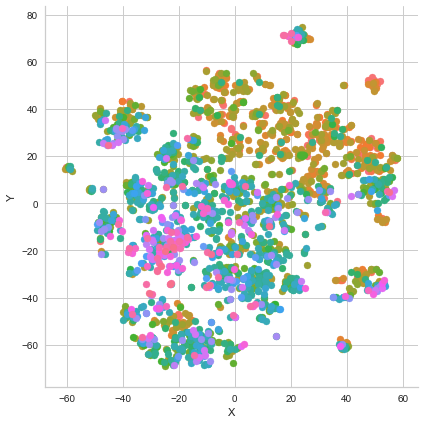

In [46]:
g = sns.FacetGrid(reduceddf, hue='label', size=6).map(plt.scatter, 'X', 'Y')

## Correlation Matrix

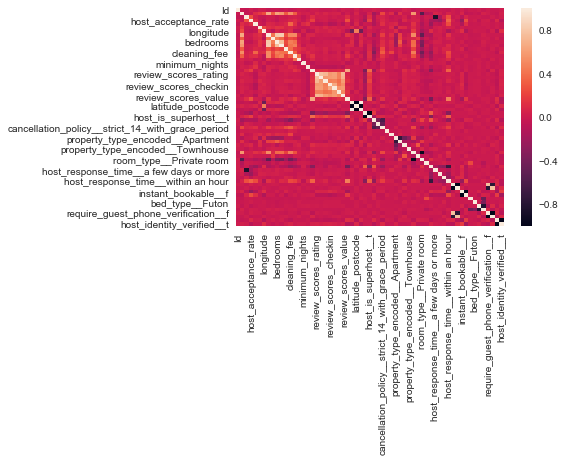

In [47]:
#Inspect the degree of correlation in features of the matrix. 
correlmatrix = train_with_dummies.corr()
sns.heatmap(correlmatrix, annot=False)
plt.show()

In [48]:
# Get dimensions of the data. To inspect that they appear as they should.
print("Training data dimensions", np.shape(train_with_dummies))
print("Testing data dimensions", np.shape(test_with_dummies))

Training data dimensions (2000, 61)
Testing data dimensions (2000, 60)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe329606390>]],
      dtype=object)

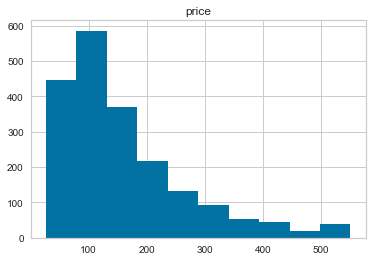

In [49]:
train_with_dummies.hist(column='price')

In [50]:
train_with_dummies.corr()['price'].sort_values(ascending = False).head(20)

price                                               1.000000
accommodates                                        0.671181
bedrooms                                            0.632011
room_type__Entire home/apt                          0.574209
beds                                                0.568871
cleaning_fee                                        0.527834
guests_included                                     0.313899
bathrooms                                           0.312642
security_deposit                                    0.310038
longitude                                           0.247899
cancellation_policy__strict_14_with_grace_period    0.229410
latitude                                            0.168807
property_type_encoded__House                        0.122891
host_listings_count                                 0.109430
cancellation_policy__super_strict_60                0.109283
review_scores_cleanliness                           0.073950
host_response_time__a fe

In [51]:
train_with_dummies.corr()['price'].sort_values(ascending = False).tail(20)

bed_type__Futon                          -0.014059
Id                                       -0.014077
host_acceptance_rate                     -0.016464
require_guest_phone_verification__t      -0.020422
host_response_time__within a few hours   -0.030975
bed_type__Pull-out Sofa                  -0.033659
bed_type__Airbed                         -0.034803
host_response_rate                       -0.037752
host_identity_verified__f                -0.038157
review_scores_value                      -0.041161
longitude_postcode                       -0.050411
Postcode                                 -0.053677
host_is_superhost__f                     -0.059364
instant_bookable__t                      -0.065898
cancellation_policy__moderate            -0.067184
host_response_time__0                    -0.074140
property_type_encoded__Apartment         -0.106603
room_type__Shared room                   -0.114419
cancellation_policy__flexible            -0.190392
room_type__Private room        

## Visualising the Distribution of Variables using Linear Regression

In [52]:
indep_variables = ["accommodates","bedrooms","bathrooms", "security_deposit", "cleaning_fee", "guests_included","room_type", "Postcode"]
dep_variable = ["price"]

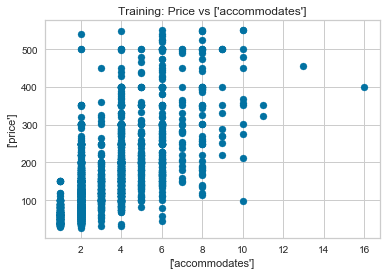

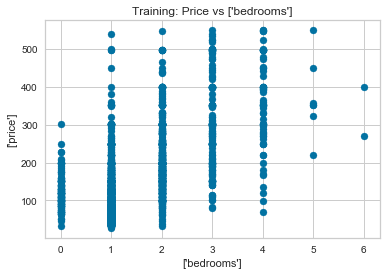

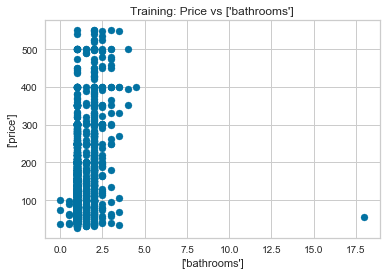

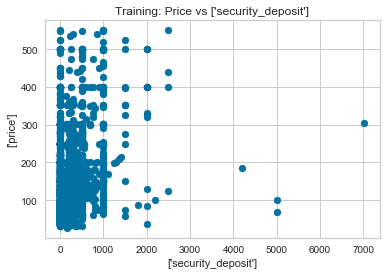

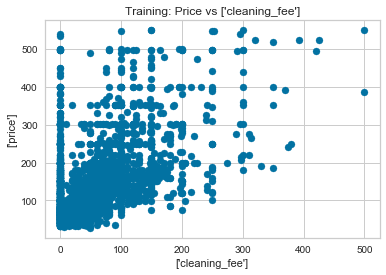

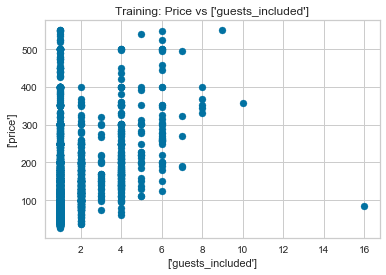

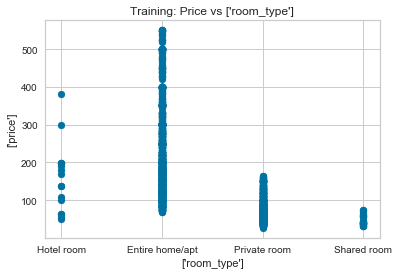

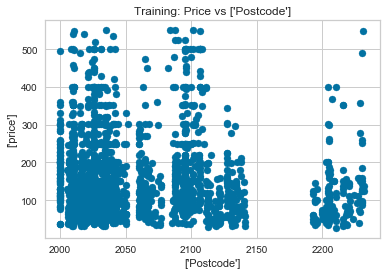

In [53]:
for i in range(len(indep_variables)):
    plt.scatter(train[indep_variables[i]], (train[dep_variable[0]]))
    plt.xlabel(str([indep_variables[i]]))
    plt.ylabel(str([dep_variable[0]]))
    plt.title("Training: Price vs "+str([indep_variables[i]]))
    plt.savefig("price vs "+indep_variables[i])
    plt.show()

Text(0.5, 1.0, 'price distribution')

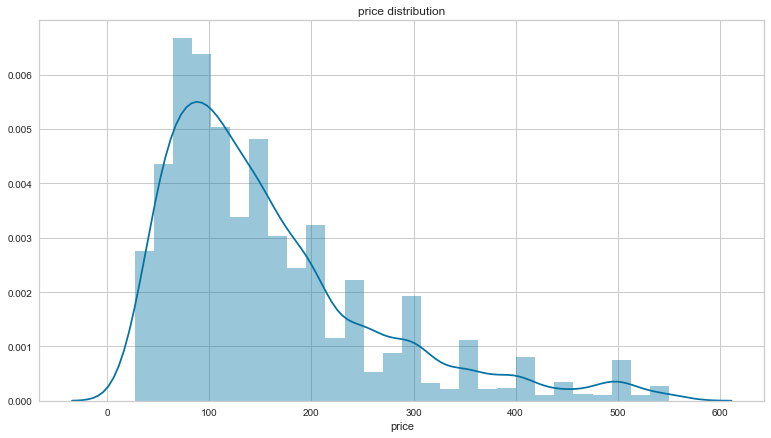

In [54]:
plt.figure(figsize=(13,7))
sns.distplot(train["price"]).set_title('price distribution')

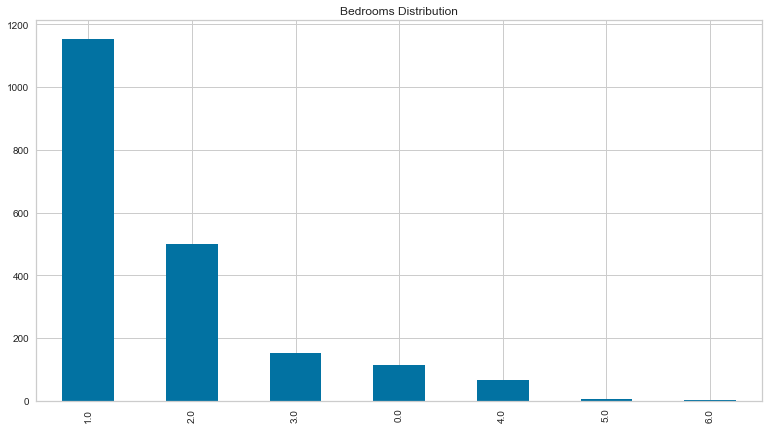

In [55]:
plt.figure(figsize=(13,7))
ax = train["bedrooms"].value_counts(normalize=False,dropna=False,sort=True).plot(kind='bar', title="Bedrooms Distribution")

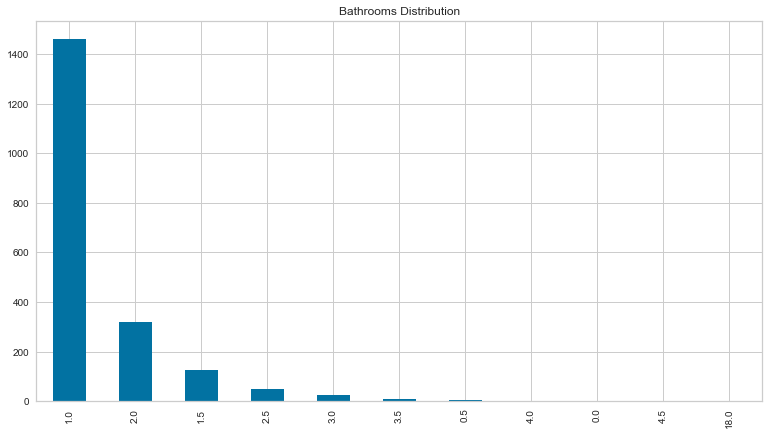

In [56]:
plt.figure(figsize=(13,7))
ax = train["bathrooms"].value_counts(normalize=False,dropna=False,sort=True).plot(kind='bar', title="Bathrooms Distribution")

Text(0.5, 1.0, 'Security_deposit Distribution')

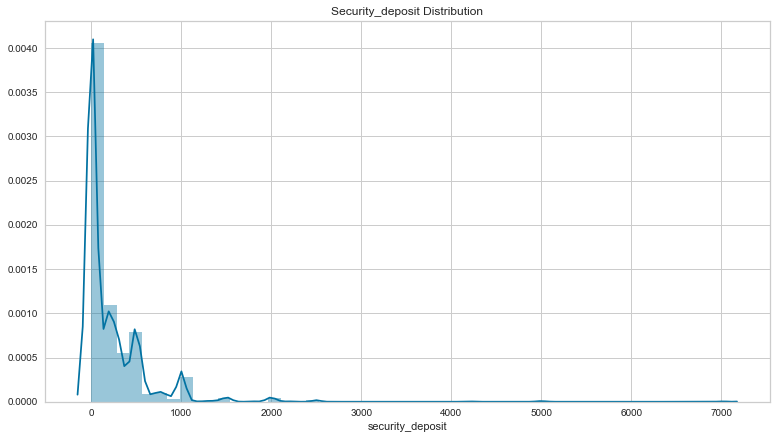

In [57]:
plt.figure(figsize=(13,7))
sns.distplot(train["security_deposit"]).set_title('Security_deposit Distribution')

Text(0.5, 1.0, 'Cleaning_fee Distribution')

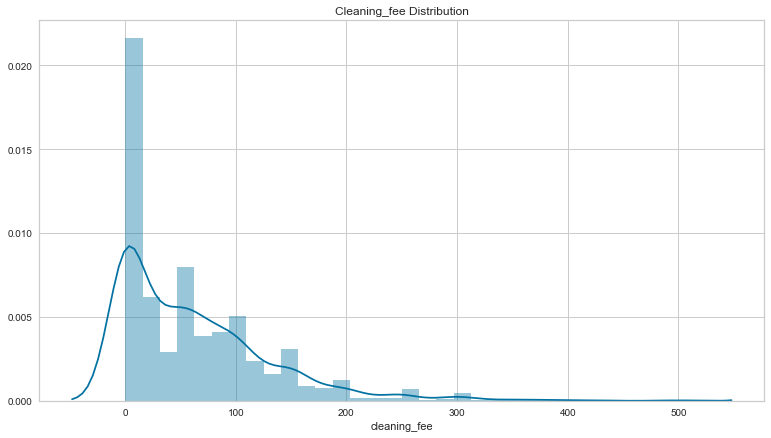

In [58]:
plt.figure(figsize=(13,7))
sns.distplot(train["cleaning_fee"]).set_title('Cleaning_fee Distribution')

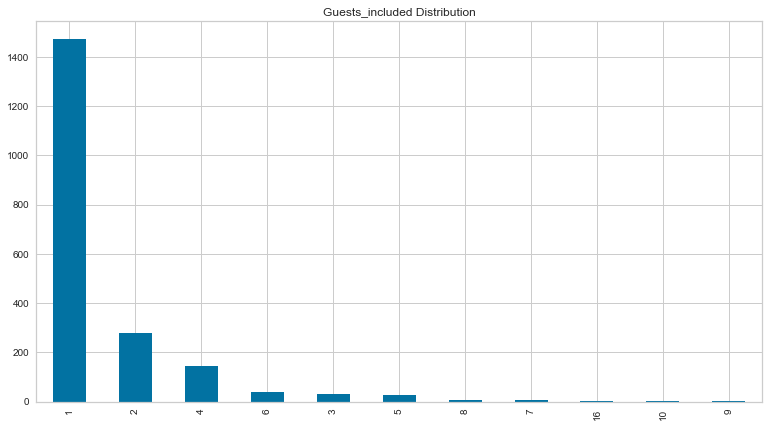

In [59]:
plt.figure(figsize=(13,7))
ax = train["guests_included"].value_counts(normalize=False,dropna=False,sort=True).plot(kind='bar', title="Guests_included Distribution")

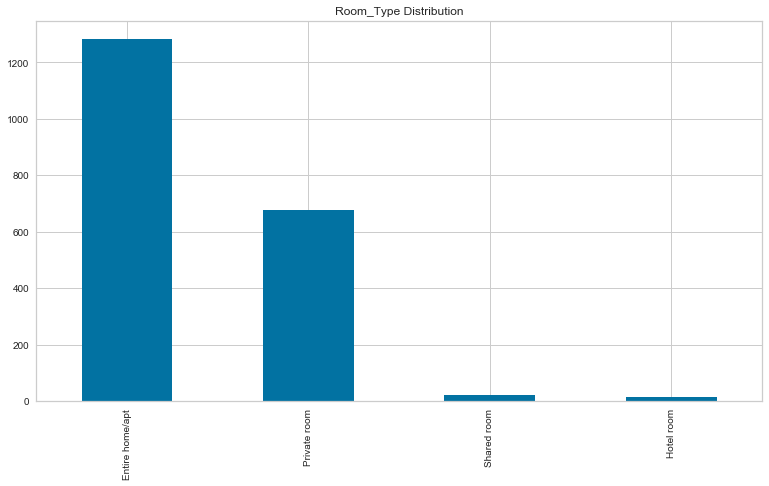

In [60]:
plt.figure(figsize=(13,7))
ax = train["room_type"].value_counts(normalize=False,dropna=False,sort=True).plot(kind='bar', title="Room_Type Distribution")

# Model Building

## Model Preparation

In [61]:
# Add a 'price' column in the test data
test_with_dummies.insert(1, 'price', '')

In [62]:
test_with_dummies.head()

,Id,price,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,instant_bookable__f,instant_bookable__t,bed_type__Couch,bed_type__Futon,bed_type__Pull-out Sofa,bed_type__Real Bed,require_guest_phone_verification__f,require_guest_phone_verification__t,host_identity_verified__f,host_identity_verified__t
0,0,,1.000000,0.570000,1,-33.776680,151.261740,1,1.0,1.0,...,1,0,0,0,0,1,1,0,0,1
1,1,,0.000000,1.000000,1,-33.795694,151.155964,4,1.0,2.0,...,1,0,0,0,0,1,1,0,0,1
2,2,,0.938955,1.000000,1,-33.874641,151.225248,2,1.0,0.0,...,1,0,0,0,0,1,1,0,1,0
3,3,,0.938955,0.819867,2,-33.898198,151.178277,2,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0
4,4,,1.000000,0.850000,1,-34.044786,151.145606,2,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0


In [63]:
# Randomly split indexes
index_train, index_test  = train_test_split(np.array(train_with_dummies.index), train_size=0.67, random_state=5)

# Set the response variable
response = 'price'

# Linear Models

# Set thepredictor variables
predictors = list(train_with_dummies.columns.values[2:])
# Write training and test sets 
train_lm = train_with_dummies.loc[index_train,:].copy()
test_lm =  train_with_dummies.loc[index_test,:].copy()
# Write training and test response vectors
y_train_lm = np.log(train_lm[response])
y_test_lm = np.log(test_lm[response])
# Write training and test design matrices
X_train_lm = train_lm[predictors].copy()
X_test_lm = test_lm[predictors].copy()

# K-Nearest Neighbours

# Set the predictors
train_with_dummies_knn = train_with_dummies[['Id','price','accommodates','bedrooms','room_type__Entire home/apt','beds','cleaning_fee','room_type__Private room']]
test_with_dummies_knn = test_with_dummies[['Id','price','accommodates','bedrooms','room_type__Entire home/apt','beds','cleaning_fee','room_type__Private room']]

train_predictors_knn = list(train_with_dummies_knn.columns.values[2:])
test_predictors_knn = list(test_with_dummies_knn.columns.values[2:])
# Write training and validation sets 
final_train_knn = train_with_dummies_knn.copy()
final_test_knn = test_with_dummies_knn.copy()
# Write training and validation sets 
train_knn = train_with_dummies_knn.loc[index_train,:].copy()
test_knn =  train_with_dummies_knn.loc[index_test,:].copy()
# Write training and test response vectors
y_train_knn = train_knn[response]
y_test_knn = test_knn[response]
y_train_knn_final = final_train_knn[response]
y_test_knn_final = final_test_knn[response]
# Write training and test design matrices
X_train_knn = train_knn[train_predictors_knn].copy()
X_test_knn = test_knn[train_predictors_knn].copy()
X_train_knn_final = final_train_knn[train_predictors_knn].copy()
X_test_knn_final = final_test_knn[test_predictors_knn].copy()

# Decision Tree

# Write training response vectors
y_train_dt = train_with_dummies["price"]
# Write training and test design matrices
X_train_dt = train_with_dummies[["accommodates", "bathrooms", "bedrooms", "security_deposit",
"cleaning_fee","room_type__Entire home/apt","room_type__Private room","longitude","guests_included",
"cancellation_policy__strict_14_with_grace_period"]]
X_test_dt = test_with_dummies[["accommodates", "bathrooms", "bedrooms", "security_deposit",
"cleaning_fee","room_type__Entire home/apt","room_type__Private room","longitude","guests_included",
"cancellation_policy__strict_14_with_grace_period"]]

# Random Forest

# Set the predictors
train_predictors = list(train_with_dummies.columns.values[2:])
test_predictors = list(test_with_dummies.columns.values[2:])
# Write training and validation sets 
final_train_rf = train_with_dummies.copy()
final_test_rf = test_with_dummies.copy()
# Write training and validation sets 
train_rf = train_with_dummies.loc[index_train,:].copy()
test_rf =  train_with_dummies.loc[index_test,:].copy()
# Write training and test response vectors
y_train_rf = train_rf[response]
y_test_rf = test_rf[response]
y_train_rf_final = final_train_rf[response]
y_test_rf_final = final_test_rf[response]
# Write training and test design matrices
X_train_rf = train_rf[train_predictors].copy()
X_test_rf = test_rf[train_predictors].copy()
X_train_rf_final = final_train_rf[train_predictors].copy()
X_test_rf_final = final_test_rf[test_predictors].copy()

# XGBoost

# Write training and test sets 
train_xgb = train_with_dummies.copy()
test_xgb =  train_with_dummies.copy()

## Model 1: Linear Models

### Lasso CV

In [64]:
scaler = StandardScaler()
scaler.fit(X_train_lm)

X_train_lm_scaled = scaler.transform(X_train_lm)
X_test_lm_scaled = scaler.transform(X_test_lm)

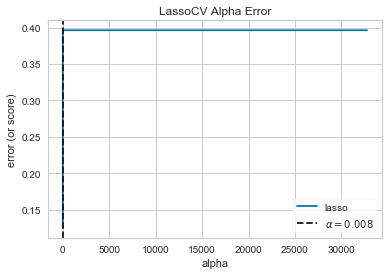

In [65]:
# Create a list of alphas to cross-validate against
alphas = list(np.logspace(-15, 15, 151, base=2))

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas, cv = 5)
visualizer = AlphaSelection(model)
visualizer.fit(X_train_lm_scaled, y_train_lm)
visualizer.show()

In [66]:
%%time
start = time.time()
lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))
lasso.fit(X_train_lm, y_train_lm)
end = time.time()
print(end - start)

0.0715179443359375
CPU times: user 533 ms, sys: 4.74 ms, total: 538 ms
Wall time: 71.7 ms


In [67]:
lasso['estimator'].alpha_

0.008330624298419034

In [68]:
reg = lasso._final_estimator # the final estimator attribute refers to the pipeline
np.sum(reg.coef_ == 0.0)

31

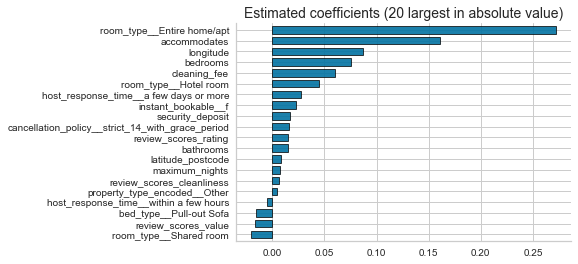

In [69]:
plot_coefficients(lasso._final_estimator, predictors) # the final_estimator attribute refers to the pipeline
plt.show()

In [70]:
from regressors import stats

stats.coef_pval(reg, X_train_lm_scaled, y_train_lm)
stats.summary(reg, X_train_lm_scaled, y_train_lm)

Residuals:
    Min      1Q  Median      3Q     Max
-1.2642 -0.2272  0.0195  0.2444  1.1159


Coefficients:
            Estimate                  Std. Error               t value   p value
_intercept  4.843929  9.427000e-03+0.000000e+00j  513.858200+0.000000j  0.000000
x1         -0.000000  3.256900e-02+9.146000e-03j    0.000000+0.000000j  1.000000
x2         -0.000000  9.745000e-03+1.146500e-02j    0.000000+0.000000j  1.000000
x3          0.000911  2.010200e-02+1.626000e-03j    0.045000-0.003600j  0.963964
x4          0.000000  4.347200e-02+4.142000e-03j    0.000000+0.000000j  1.000000
x5          0.086704  2.519000e-02+2.584000e-03j    3.406200-0.349400j  0.000636
x6          0.160747  1.924900e-02+2.180000e-03j    8.245300-0.933900j  0.000000
x7          0.014561  1.453800e-02+7.280000e-04j    0.999100-0.050100j  0.317311
x8          0.075207  1.650400e-02-6.700000e-05j    4.556900+0.018500j  0.000006
x9          0.000000  1.794400e-02+1.414000e-03j    0.000000+0.000000j  1.000000
x1

### Ridge CV

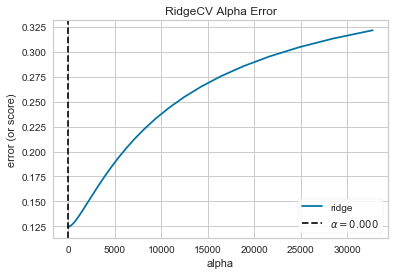

In [71]:
# Create a list of alphas to cross-validate against
alphas = list(np.logspace(-15, 15, 151, base=2))

# Instantiate the linear model and visualizer
model1 = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model1)
visualizer.fit(X_train_lm_scaled, y_train_lm)
visualizer.show()

In [72]:
%%time
warnings.filterwarnings("ignore", category=DeprecationWarning) # This line of code ignores a deprecation warning

alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train_lm, y_train_lm)

CPU times: user 10.5 s, sys: 35.8 ms, total: 10.5 s
Wall time: 1.32 s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 RidgeCV(alphas=array([3.05175781e-05, 3.50554918e-05, 4.02681858e-05, 4.62559987e-05,
       5.31341897e-05, 6.10351562e-05, 7.01109836e-05, 8.05363715e-05,
       9.25119975e-05, 1.06268379e-04, 1.22070312e-04, 1.40221967e-04,
       1.61072743e-04, 1.85023995e-04, 2.12536759e...
       2.70235220e+03, 3.10418753e+03, 3.56577511e+03, 4.09600000e+03,
       4.70506846e+03, 5.40470440e+03, 6.20837506e+03, 7.13155021e+03,
       8.19200000e+03, 9.41013692e+03, 1.08094088e+04, 1.24167501e+04,
       1.42631004e+04, 1.63840000e+04, 1.88202738e+04, 2.16188176e+04,
       2.48335002e+04, 2.85262009e+04, 3.27680000e+04]),
                         cv=5, fit_intercept=True, gcv_mode=None,
                         normalize=False, scoring=None,
                         store_cv_values=False))],
         verbose=False)

In [73]:
ridge['estimator'].alpha_

0.00010626837930860896

In [74]:
reg0 = ridge._final_estimator

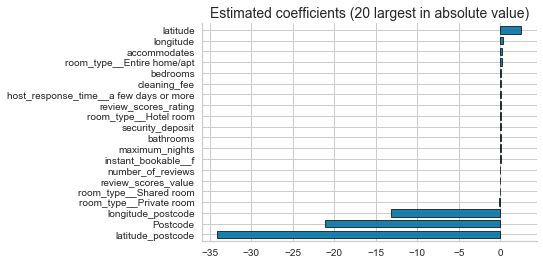

In [75]:
plot_coefficients(ridge._final_estimator, predictors) # the final_estimator attribute refers to the pipeline
plt.show()

In [76]:
from regressors import stats

stats.coef_pval(reg0, X_train_lm_scaled, y_train_lm)
stats.summary(reg0, X_train_lm_scaled, y_train_lm)

Residuals:
    Min      1Q  Median      3Q     Max
-1.2595 -0.2185  0.0119  0.2287  1.0805


Coefficients:
             Estimate                  Std. Error               t value   p value
_intercept   4.843929  9.250000e-03+0.000000e+00j  523.647000+0.000000j  0.000000
x1           0.010528  1.840100e-02+3.148700e-02j    0.145700-0.249200j  0.772872
x2           0.001990  1.916600e-02+6.288000e-03j    0.093700-0.030800j  0.921432
x3           0.006612  1.555000e-02+5.924000e-03j    0.371300-0.141500j  0.691182
x4           2.506677  3.664600e-02+4.106000e-03j   67.554900-7.568600j  0.000000
x5           0.279395  2.129100e-02-2.873000e-02j    4.651900+6.277400j  0.000000
x6           0.169775  2.769400e-02+5.159000e-03j    5.924900-1.103700j  0.000000
x7           0.019023  1.745000e-02+6.663000e-03j    0.951400-0.363300j  0.308675
x8           0.081660  2.244400e-02+2.191000e-03j    3.604100-0.351900j  0.000304
x9          -0.011719  2.027500e-02+2.194000e-03j   -0.571300+0.061800j  

### Elastic Net 

In [77]:
%%time

enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train_lm, y_train_lm)

CPU times: user 5.47 s, sys: 19 ms, total: 5.49 s
Wall time: 687 ms


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001,
                              fit_intercept=True,
                              l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                        0.8, 0.9, 0.99],
                              max_iter=1000, n_alphas=100, n_jobs=None,
                              normalize=False, positive=False,
                              precompute='auto', random_state=None,
                              selection='cyclic', tol=0.0001, verbose=0))],
         verbose=False)

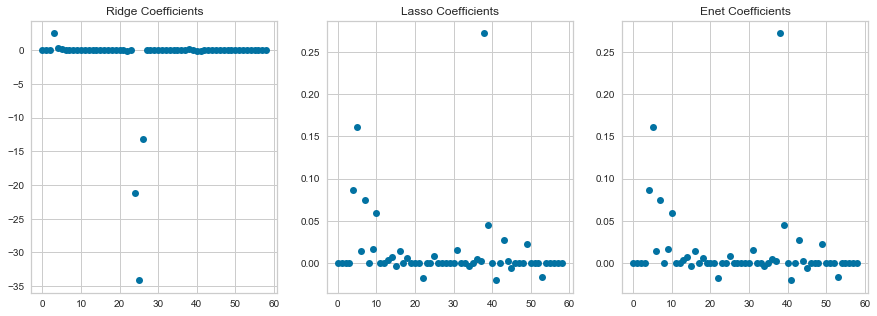

In [78]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(ridge['estimator'].coef_, 'o')
plt.title('Ridge Coefficients')

plt.subplot(1, 3, 2)
plt.plot(lasso['estimator'].coef_, 'o')
plt.title('Lasso Coefficients');

plt.subplot(1, 3, 3)
plt.plot(enet['estimator'].coef_, 'o')
plt.title('Enet Coefficients');

In [79]:
# Re-specifying the two models
methods = [lasso, ridge, enet]

# Initialise table
columns = ['RMSE', 'R-Squared', 'MAE']
rows = ['LassoCV', 'RidgeCV', 'Elastic Net CV']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# Computer cross-validation predictions and metrics
for i, method in enumerate(methods):
    y_pred = cross_val_predict(method, X_train_lm, y_train_lm, cv = 5, n_jobs=4)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(np.exp(y_train_lm), np.exp(y_pred)))
    results.iloc[i, 1] = r2_score(np.exp(y_train_lm), np.exp(y_pred))
    results.iloc[i, 2] = mean_absolute_error(np.exp(y_train_lm), np.exp(y_pred))

results.round(3)

,RMSE,R-Squared,MAE
LassoCV,64.959,0.604,43.311
RidgeCV,64.585,0.608,42.899
Elastic Net CV,64.951,0.604,43.317


In [80]:
columns = ['Test RMSE', 'Test R2', 'Test MAE']
rows = ['LassoCV', 'RidgeCV', 'Elastic Net']
results = pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [lasso, ridge, enet]
for i, method in enumerate(methods):
    y_pred=np.exp(method.predict(X_test_lm.values))
    results.iloc[i,0] = np.sqrt(mean_squared_error(np.exp(y_test_lm), (y_pred)))
    results.iloc[i,1] = r2_score(np.exp(y_test_lm), (y_pred))
    results.iloc[i, 2] = mean_absolute_error(np.exp(y_test_lm), (y_pred))
    
results.round(3)

,Test RMSE,Test R2,Test MAE
LassoCV,74.427,0.529,48.290
RidgeCV,73.301,0.543,47.536
Elastic Net,74.427,0.529,48.290


### Kaggle's performance measures for three regularised linear models


In [81]:
test_predictors_lm = list(test_with_dummies.columns.values[2:])
X_tester_lm = test_with_dummies[test_predictors_lm].copy()

In [82]:
np.set_printoptions(threshold=np.inf)
yhat = np.exp(ridge.predict(X_tester_lm))
DF00 = pd.DataFrame(np.c_[X_tester_lm.index, yhat], columns=['Id', response])
DF00['Id'] = DF00['Id'].astype(int)
DF00.to_csv('Ridge.csv',  index=False) # 76.02415

In [83]:
np.set_printoptions(threshold=np.inf)
yhat = np.exp(lasso.predict(X_tester_lm))
DF01 = pd.DataFrame(np.c_[X_tester_lm.index, yhat], columns=['Id', response])
DF01['Id'] = DF01['Id'].astype(int)
DF01.to_csv('Lasso.csv',  index=False) # 71.15169

In [84]:
np.set_printoptions(threshold=np.inf)
yhat = np.exp(enet.predict(X_tester_lm))
DF02 = pd.DataFrame(np.c_[X_tester_lm.index, yhat], columns=['Id', response])
DF02['Id'] = DF02['Id'].astype(int)
DF02.to_csv('Enet.csv',  index=False) # 71.15199

## Model 2: K-Nearest Neighbours

In [85]:
scaler = StandardScaler()
scaler.fit(X_train_knn)

X_train_knn = scaler.transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)

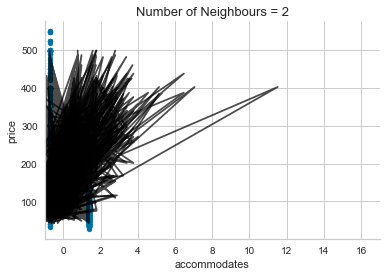

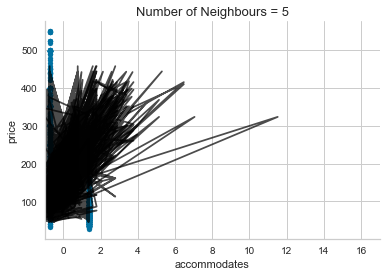

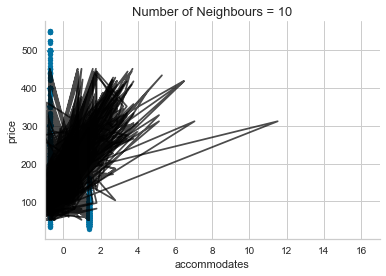

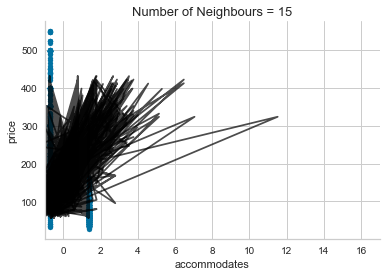

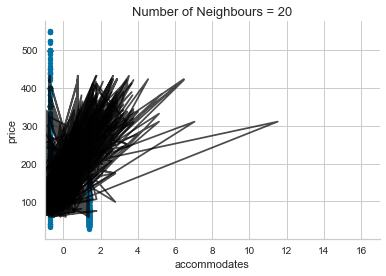

In [94]:
x = np.linspace(train['accommodates'].min(), train['accommodates'].max(), 500).reshape((-1, 1))

for K in [2, 5, 10, 15, 20]:
    
    # Specify and fit model
    knn = KNeighborsRegressor(n_neighbors=K) 
    knn.fit(X_train_knn, y_train_knn)

    # Compute the predicted values for each point in the grid
    y_pred = knn.predict(X_test_knn)

    # Plot figuer
    fig, ax = plt.subplots()
    
    ax.scatter(X_train_knn[:,5], y_train_knn.values, s=25) 
    ax.plot(X_test_knn, y_pred, color='black', alpha=0.7)
    
    ax.set_title(f'Number of Neighbours = {K}', fontsize=13)
    ax.set_xlabel('accommodates')
    ax.set_ylabel('price')
    ax.set_xlim(-1, 17)
    sns.despine()
    plt.show()

In [95]:
%%time 

knn = KNeighborsRegressor(n_neighbors=10) # we should specify the number of neighbours
knn.fit(X_train_knn, y_train_knn)

y_pred_knn = knn.predict(X_test_knn_final)

CPU times: user 16.3 ms, sys: 1.46 ms, total: 17.7 ms
Wall time: 16.2 ms


In [96]:
# Initialise table
columns = ['RMSE', 'R-Squared', 'MAE']
rows = ['K-NN']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods_knn = [knn] 

# Computer cross-validation predictions and metrics
for i, method in enumerate(methods_knn):
    y_pred = cross_val_predict(method, X_train_knn, y_train_knn, cv = 5, n_jobs=4)
    results.iloc[i, 0] = np.sqrt(mean_squared_error((y_train_knn), (y_pred)))
    results.iloc[i, 1] = r2_score((y_train_knn), (y_pred))
    results.iloc[i, 2] = mean_absolute_error((y_train_knn), (y_pred))

results.round(3)

,RMSE,R-Squared,MAE
K-NN,68.934,0.554,48.197


In [97]:
# Initialise table
columns = ['RMSE', 'R-Squared','MAE']
rows = ['K-NN']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [knn] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(X_test_knn)
    results.iloc[i, 0] = np.sqrt(mean_squared_error((y_test_knn), (y_pred)))
    results.iloc[i, 1] = r2_score(y_test_knn, y_pred)
    results.iloc[i, 2] = mean_absolute_error((y_test_knn), (y_pred))

results.round(3)

,RMSE,R-Squared,MAE
K-NN,73.962,0.535,50.881


In [98]:
submission = pd.DataFrame(np.c_[test.index, y_pred_knn], columns=['Id', 'price'])
submission['Id'] = submission['Id'].astype('int')
submission.to_csv('KNN.csv', index=False) 

## Model 3: Decision Tree

In [99]:
tree = DecisionTreeRegressor(criterion='mse',max_depth=8,max_leaf_nodes=20,min_samples_leaf=40,min_samples_split=10)

In [100]:
%%time
# Hyperparameter Tuning
param_grid = {
              "min_samples_split": [10, 20, 40],
              "max_depth": [6, 8, 10],
              "min_samples_leaf": [5, 20, 40],
              "max_leaf_nodes": [20, 60,100],
              "splitter":["best","random"],               
              "min_weight_fraction_leaf":[0.0,0.2,0.4],
              "max_features":["auto","log2","sqrt",None], 
              }

# Fit the final model 
grid_cv_tree = GridSearchCV(tree, param_grid, cv=10)
grid_cv_tree.fit(X_train_dt,y_train_dt)
y_pred_dt = grid_cv_tree.predict(X_test_dt)

CPU times: user 55.3 s, sys: 125 ms, total: 55.4 s
Wall time: 55.5 s


In [101]:
# Print out the best parameters
print(grid_cv_tree.best_params_)

{'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_samples_split': 40, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}


In [102]:
tree = DecisionTreeRegressor(criterion='mse',max_depth=6 ,max_leaf_nodes=100,min_samples_leaf=5,min_samples_split=10, min_weight_fraction_leaf= 0.0)
model = tree.fit(X_train_dt,y_train_dt)

In [103]:
submission = pd.DataFrame(np.c_[test.index, y_pred_dt], columns=['Id', 'price'])
submission['Id'] = submission['Id'].astype('int')
submission.to_csv('Decision Tree.csv', index=False) 

In [104]:
from sklearn import tree
text_representation = tree.export_text(model)
print(text_representation)

|--- feature_0 <= 3.50
|   |--- feature_5 <= 0.50
|   |   |--- feature_0 <= 1.50
|   |   |   |--- feature_6 <= 0.50
|   |   |   |   |--- feature_7 <= 151.21
|   |   |   |   |   |--- feature_7 <= 151.20
|   |   |   |   |   |   |--- value: [45.40]
|   |   |   |   |   |--- feature_7 >  151.20
|   |   |   |   |   |   |--- value: [36.67]
|   |   |   |   |--- feature_7 >  151.21
|   |   |   |   |   |--- value: [52.00]
|   |   |   |--- feature_6 >  0.50
|   |   |   |   |--- feature_7 <= 151.17
|   |   |   |   |   |--- feature_3 <= 190.00
|   |   |   |   |   |   |--- value: [51.61]
|   |   |   |   |   |--- feature_3 >  190.00
|   |   |   |   |   |   |--- value: [66.33]
|   |   |   |   |--- feature_7 >  151.17
|   |   |   |   |   |--- feature_4 <= 25.50
|   |   |   |   |   |   |--- value: [64.18]
|   |   |   |   |   |--- feature_4 >  25.50
|   |   |   |   |   |   |--- value: [74.05]
|   |   |--- feature_0 >  1.50
|   |   |   |--- feature_4 <= 40.50
|   |   |   |   |--- feature_6 <= 0.50
|   |  

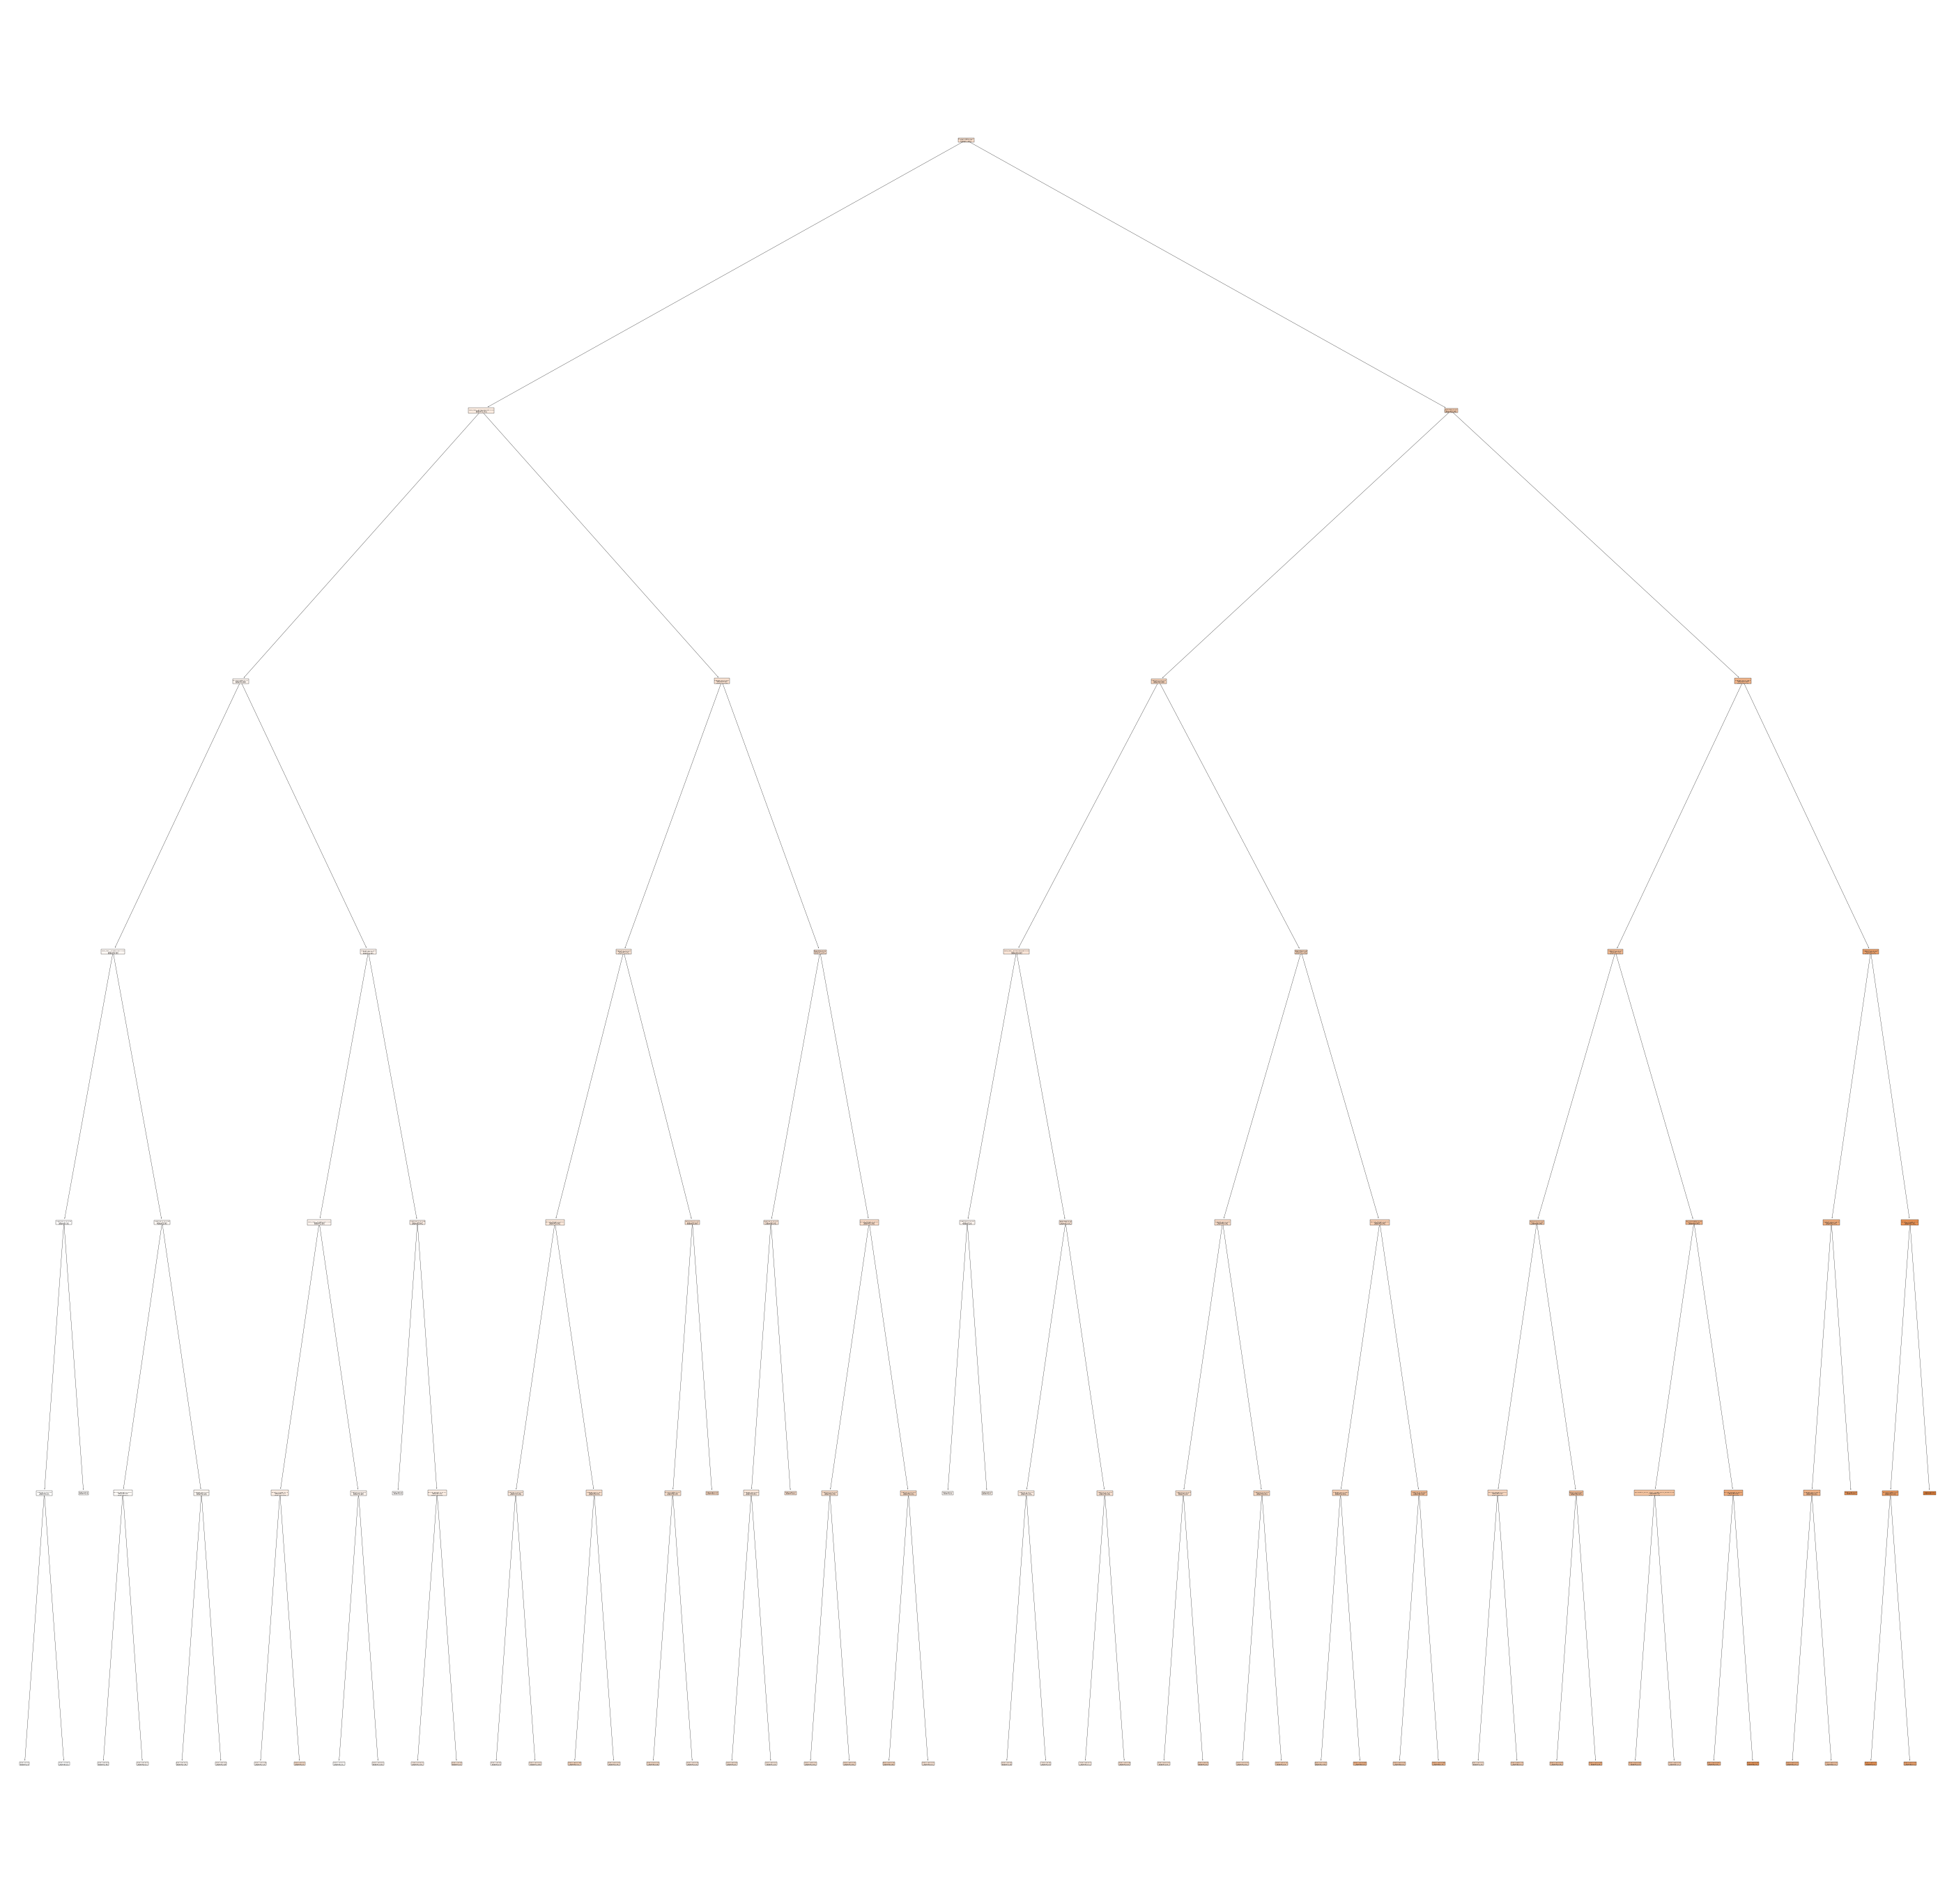

In [105]:
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(model, 
                   feature_names=X_train_dt.columns, 
                   filled=True)

In [106]:
#conda uninstall python-graphviz
#pip install dtreeviz

In [107]:
#from dtreeviz.trees import dtreeviz

#airbnbviz = dtreeviz(model, X_train_dt,y_train_dt, target_name="price", feature_names=X_train_dt.columns)

#airbnbviz

## Model 4: Random Forest 

In [108]:
randomforest = RandomForestRegressor()

params_randomforest = {'n_estimators': [500, 550, 600, 650, 700, 750],
                      'min_samples_leaf': [2, 4, 6, 8, 10],
                      'max_features': np.arange(1, X_train_rf.shape[1])}

randomforest_rs = RandomizedSearchCV(randomforest, params_randomforest,
                                     cv=15, n_iter= 16, return_train_score=False,
                                     n_jobs= 4, random_state = 20)

In [109]:
randomforest_rs.fit(X_train_rf, y_train_rf)

RandomizedSearchCV(cv=15, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [110]:
randomforest_best = randomforest_rs.best_estimator_

In [111]:
print(randomforest_rs.best_params_)

{'n_estimators': 550, 'min_samples_leaf': 2, 'max_features': 10}


In [112]:
y_pred_rf = randomforest_best.predict(X_test_rf.values)

In [113]:
# Re-specifying the models
methods = [randomforest]

# Initialise table
columns = ['RMSE', 'R-Squared', 'MAE']
rows = ['RandomForest']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# Computer cross-validation predictions and metrics
for i, method in enumerate(methods):
    y_pred = cross_val_predict(randomforest_best, X_train_rf, y_train_rf, cv = 5, n_jobs=4)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train_rf, y_pred))
    results.iloc[i, 1] = r2_score(y_train_rf, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_train_rf, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
RandomForest,61.313,0.647,42.839


In [114]:
# Re-specifying the models
methods = [randomforest]

# Initialise table
columns = ['Test RMSE', 'Test R-Squared', 'Test MAE']
rows = ['RandomForest']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# Computer cross-validation predictions and metrics

for i, method in enumerate(methods):
    y_pred = randomforest_best.predict(X_test_rf.values)
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test_rf, y_pred))
    results.iloc[i,1] = r2_score(y_test_rf, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_test_rf, y_pred)
    
results.round(3)

,Test RMSE,Test R-Squared,Test MAE
RandomForest,68.481,0.601,46.048


In [115]:
importance = randomforest_best.feature_importances_

In [116]:
# Create the list of predictors 
predictor_list = list(X_train_rf.columns)

# Obtain the predictor importances from highest to lowest
predictor_importance= sorted(zip(importance, predictor_list), reverse=True)

# Create the predictor and importance Dataframe and separate lists
predictor_importance_dataframe = pd.DataFrame(predictor_importance, columns=['importance', 'predictor'])
importance= list(predictor_importance_dataframe['importance'])
predictor= list(predictor_importance_dataframe['predictor'])

print(predictor_importance_dataframe)

    importance                                         predictor
0     0.128258                                      accommodates
1     0.126519                                          bedrooms
2     0.087164                        room_type__Entire home/apt
3     0.084718                                              beds
4     0.074284                                      cleaning_fee
5     0.059552                           room_type__Private room
6     0.046333                                         longitude
7     0.039911                                         bathrooms
8     0.038197                                  security_deposit
9     0.027543                                          latitude
10    0.024407                                longitude_postcode
11    0.024166                                 latitude_postcode
12    0.020728                                    minimum_nights
13    0.018259                                          Postcode
14    0.017635           

In [117]:
rf_final = RandomForestRegressor()

params_rf = {'n_estimators': [500, 550, 600, 650, 700, 750],
             'min_samples_leaf': [2, 4, 6],
             'max_features': np.arange(1, X_train_rf_final.shape[1])}

rf_rs = RandomizedSearchCV(rf_final, params_rf, cv=15, n_iter= 16, return_train_score=False,
                           n_jobs= 4, random_state = 20)

In [118]:
%%time

rf_rs.fit(X_train_rf_final, y_train_rf_final)

CPU times: user 2.27 s, sys: 72.8 ms, total: 2.35 s
Wall time: 4min 30s


RandomizedSearchCV(cv=15, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [119]:
rf_best = rf_rs.best_estimator_
print(rf_rs.best_params_)

{'n_estimators': 550, 'min_samples_leaf': 2, 'max_features': 7}


In [120]:
y_pred_rf_final = rf_best.predict(X_test_rf_final.values)

In [121]:
submission = pd.DataFrame(np.c_[final_test_rf.index, y_pred_rf_final], columns=['Id', response])
submission['Id'] = submission['Id'].astype(int)
submission.to_csv('Random Forests_tuned.csv',  index=False)

In [122]:
importance = rf_best.feature_importances_

In [123]:
# Create the list of predictors 
predictor_list = list(X_train_rf_final.columns)

# Obtain the predictor importances from highest to lowest
predictor_importance= sorted(zip(importance, predictor_list), reverse=True)

# Create the predictor and importance Dataframe and separate lists
predictor_importance_dataframe = pd.DataFrame(predictor_importance, columns=['importance', 'predictor'])
importance= list(predictor_importance_dataframe['importance'])
predictor= list(predictor_importance_dataframe['predictor'])

print(predictor_importance_dataframe)

    importance                                         predictor
0     0.120744                                      accommodates
1     0.103632                                          bedrooms
2     0.085030                        room_type__Entire home/apt
3     0.076557                           room_type__Private room
4     0.072903                                      cleaning_fee
5     0.072074                                              beds
6     0.042243                                         longitude
7     0.037909                                  security_deposit
8     0.037485                                         bathrooms
9     0.031185                                          latitude
10    0.026211                                 latitude_postcode
11    0.025397                                longitude_postcode
12    0.021399                                          Postcode
13    0.019275                                   guests_included
14    0.018953           

In [124]:
predictor_importance_dataframe['importance'] = predictor_importance_dataframe['importance']*100
predictors = predictor_importance_dataframe
predictors[:21]

,importance,predictor
0,12.074393,accommodates
1,10.363153,bedrooms
2,8.503045,room_type__Entire home/apt
3,7.655659,room_type__Private room
4,7.290342,cleaning_fee
5,7.207404,beds
6,4.224319,longitude
7,3.790945,security_deposit
8,3.748468,bathrooms
9,3.118535,latitude


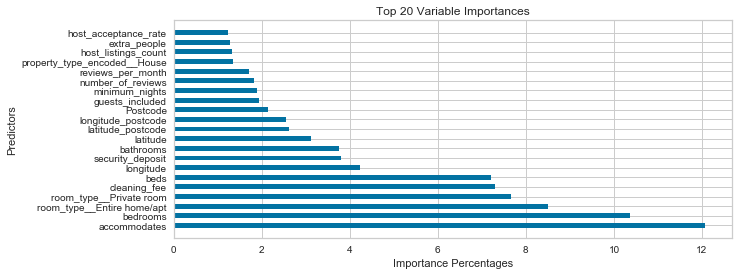

In [125]:
plt.figure(figsize=(10,4))
plt.barh('predictor', 'importance', data = predictors[:21], height = 0.5)
plt.xlabel('Importance Percentages')
plt.ylabel('Predictors')
plt.title('Top 20 Variable Importances')
plt.savefig('Random Forest Variable Importance.png')
plt.show()

## Model 5: XGBoost

In [126]:
#Inspect the data after the wrangling for random forest.
train_xgb

,Id,price,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,instant_bookable__f,instant_bookable__t,bed_type__Airbed,bed_type__Futon,bed_type__Pull-out Sofa,bed_type__Real Bed,require_guest_phone_verification__f,require_guest_phone_verification__t,host_identity_verified__f,host_identity_verified__t
0,2000,199,1.000000,1.000000,5,-33.918732,151.242035,2,1.0,0.0,...,0,1,0,0,0,1,1,0,1,0
1,2001,95,0.948178,0.830000,1,-33.698425,151.290979,4,1.0,1.0,...,0,1,0,0,0,1,1,0,1,0
2,2002,156,0.910000,0.980000,8,-33.847388,151.072890,4,1.0,2.0,...,1,0,0,0,0,1,1,0,1,0
3,2003,100,0.990000,0.970000,260,-33.870261,151.195131,2,1.0,1.0,...,0,1,0,0,0,1,1,0,1,0
4,2004,100,1.000000,0.828026,1,-33.908168,151.211849,1,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3995,45,1.000000,0.990000,23,-33.881002,151.216918,2,1.0,1.0,...,0,1,0,0,0,1,1,0,0,1
1996,3996,108,1.000000,0.950000,9,-33.868943,151.191446,2,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0
1997,3997,120,1.000000,0.950000,5,-33.885611,151.200060,2,1.0,1.0,...,1,0,0,0,0,1,1,0,0,1
1998,3998,90,0.800000,0.500000,3,-33.867824,151.170051,1,2.5,1.0,...,1,0,0,0,0,1,1,0,0,1


In [127]:
#Inspect the data after the wrangling for random forest.
test_xgb

,Id,price,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,instant_bookable__f,instant_bookable__t,bed_type__Airbed,bed_type__Futon,bed_type__Pull-out Sofa,bed_type__Real Bed,require_guest_phone_verification__f,require_guest_phone_verification__t,host_identity_verified__f,host_identity_verified__t
0,2000,199,1.000000,1.000000,5,-33.918732,151.242035,2,1.0,0.0,...,0,1,0,0,0,1,1,0,1,0
1,2001,95,0.948178,0.830000,1,-33.698425,151.290979,4,1.0,1.0,...,0,1,0,0,0,1,1,0,1,0
2,2002,156,0.910000,0.980000,8,-33.847388,151.072890,4,1.0,2.0,...,1,0,0,0,0,1,1,0,1,0
3,2003,100,0.990000,0.970000,260,-33.870261,151.195131,2,1.0,1.0,...,0,1,0,0,0,1,1,0,1,0
4,2004,100,1.000000,0.828026,1,-33.908168,151.211849,1,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3995,45,1.000000,0.990000,23,-33.881002,151.216918,2,1.0,1.0,...,0,1,0,0,0,1,1,0,0,1
1996,3996,108,1.000000,0.950000,9,-33.868943,151.191446,2,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0
1997,3997,120,1.000000,0.950000,5,-33.885611,151.200060,2,1.0,1.0,...,1,0,0,0,0,1,1,0,0,1
1998,3998,90,0.800000,0.500000,3,-33.867824,151.170051,1,2.5,1.0,...,1,0,0,0,0,1,1,0,0,1


In [128]:
#We need to drop these columns as there is only one observation in the test set with a value couch and none in the training set. So the XGBoost Regressor does not consider these features.

# test_xgb = test_xgb.drop('bed_type__Couch', 1)    #This doesn't show up

train_xgb = train_xgb.drop('bed_type__Airbed', 1)
test_xgb = test_xgb.drop('Id', 1)
train_xgb = train_xgb.drop('Id', 1)
test_xgb = test_xgb.drop('price', 1)

In [129]:
#Convert all features to numeric after implementing dummy variables.
traincols = train_xgb.columns
train_xgb[traincols] = train_xgb[traincols].apply(pd.to_numeric, errors='coerce', axis=1)

In [130]:
#Convert all features to numeric after implementing dummy variables.
testcols = test_xgb.columns
test_xgb[testcols] = test_xgb[testcols].apply(pd.to_numeric, errors='coerce', axis=1)

In [131]:
train_xgb.head()

,price,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,require_guest_profile_picture__t,instant_bookable__f,instant_bookable__t,bed_type__Futon,bed_type__Pull-out Sofa,bed_type__Real Bed,require_guest_phone_verification__f,require_guest_phone_verification__t,host_identity_verified__f,host_identity_verified__t
0,199.0,1.000000,1.000000,5.0,-33.918732,151.242035,2.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,95.0,0.948178,0.830000,1.0,-33.698425,151.290979,4.0,1.0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,156.0,0.910000,0.980000,8.0,-33.847388,151.072890,4.0,1.0,2.0,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,100.0,0.990000,0.970000,260.0,-33.870261,151.195131,2.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,100.0,1.000000,0.828026,1.0,-33.908168,151.211849,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [132]:
test_xgb.head()

,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,...,instant_bookable__f,instant_bookable__t,bed_type__Airbed,bed_type__Futon,bed_type__Pull-out Sofa,bed_type__Real Bed,require_guest_phone_verification__f,require_guest_phone_verification__t,host_identity_verified__f,host_identity_verified__t
0,1.000000,1.000000,5.0,-33.918732,151.242035,2.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.948178,0.830000,1.0,-33.698425,151.290979,4.0,1.0,1.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.910000,0.980000,8.0,-33.847388,151.072890,4.0,1.0,2.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.990000,0.970000,260.0,-33.870261,151.195131,2.0,1.0,1.0,1.0,500.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1.000000,0.828026,1.0,-33.908168,151.211849,1.0,1.0,1.0,1.0,400.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [133]:
from scipy import stats
#Collect the z-scores for the observations in the training dataset. This will help to remove outliers.
zscores = np.abs(stats.zscore(train_xgb))
#print(zscores)

In [134]:
#Create a new dataframe wiht outliers removed.
train_with_dummies_o = train_xgb[(zscores < 4).all(axis=1)]

In [135]:
#Inspect how many values were removed as outliers.
train_with_dummies_o.shape

(1635, 59)

In [136]:
#Split the response (price) from the predictors.
X = train_with_dummies_o.iloc[:,1:]
Y = train_with_dummies_o.iloc[:,0]

In [137]:
#Y = np.log(Y)

In [138]:
#Split into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.33, random_state=100)

In [139]:
#Check that all datasets have the same number of features.
X_train.shape, X_val.shape, test_xgb.shape

((1095, 58), (540, 58), (2000, 59))

In [140]:
# Find the mean from the training data
meantrain = np.mean(y_train)
# Get predictions on the test set
baselpreds = np.ones(y_val.shape) * meantrain
# Compute MAE
maebase = mean_absolute_error(y_val, baselpreds)
print("Baseline MAE is {:.2f}".format(maebase))

Baseline MAE is 73.32


In [141]:
%%time

xgbmodel = xgb.XGBRegressor() #Select the XGBRegressor model.

#Specify the parameter values we want to tune.
tuningparams = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [3, 5, 7],
    'subsample' : [0.4, 0.6, 0.8, 1.0],
}

CPU times: user 37 µs, sys: 11 µs, total: 48 µs
Wall time: 52 µs


In [142]:
%%time
#Run hyperparameter tuning.
xgbsearch = RandomizedSearchCV(xgbmodel, tuningparams, n_iter = 10, cv = 10, return_train_score=False, 
                               #n_jobs=2, 
                               random_state = 30)

CPU times: user 14 µs, sys: 1e+03 ns, total: 15 µs
Wall time: 17.9 µs


In [143]:
train_x = X_train.values #Convert to numpy array for model stacking later.

#Fit the model using the training values.
xgbsearch.fit(train_x, y_train)

xgboost = xgbsearch.best_estimator_

print('Best parameters:', xgbsearch.best_params_, '\n')

Best parameters: {'subsample': 0.8, 'n_estimators': 750, 'max_depth': 7, 'learning_rate': 0.01} 



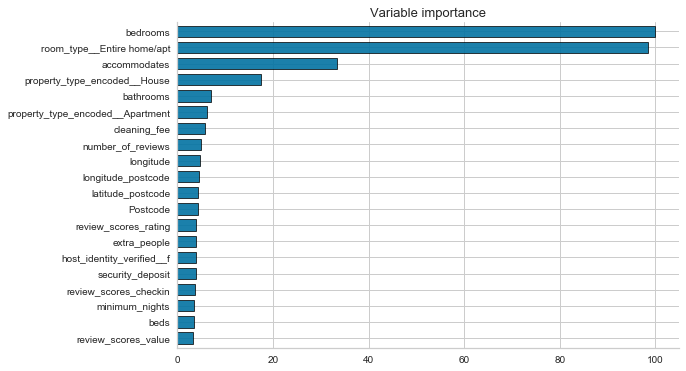

In [144]:
#Plot variable importance.
features=list(X_train.columns)
plot_feature_importance(xgboost, features)
plt.show()

In [145]:
%%time

#Convert the data to Dmatrices as required for the XGBoost algorithm.
xgb_train_data = xgb.DMatrix(X_train, y_train, enable_categorical=True) 
xgb_test_data  = xgb.DMatrix(X_val, enable_categorical=True)

#Specify the best performing parameters as 
bestparams = {
    'max_depth': 7, 
    'learning_rate': 0.01, 
    'subsample': 0.8,
    'objective': 'reg:squarederror',  
     }

crossval = xgb.cv(bestparams, xgb_train_data, num_boost_round = 750, nfold=10, early_stopping_rounds=50, verbose_eval=False)

print(f'RMSE (CV): {crossval.iloc[-1,0]:.4f}');

RMSE (CV): 21.2789
CPU times: user 2min 8s, sys: 2.27 s, total: 2min 10s
Wall time: 8.48 s


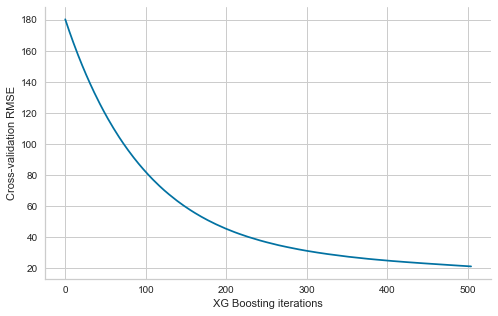

In [146]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(crossval.iloc[:,0])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('XG Boosting iterations')
sns.despine()
plt.show()

In [147]:
# Initialise table
columns = ['RMSE', 'R-Squared','MAE']
rows = ['XGBoost']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [xgboost] 

# Computer training predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(train_x)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train, y_pred))
    results.iloc[i, 1] = r2_score(y_train, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_train, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
XGBoost,15.823,0.974,10.941


In [148]:
val_x = X_val.values #Convert to numpy array

# Computer val predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(val_x)
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_val, y_pred))
    results.iloc[i,1] = r2_score(y_val, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_val, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
XGBoost,63.014,0.578,42.304


## Model 6: Model Stacking

In [149]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor

In [150]:
%%time

rfmodel = RandomForestRegressor(n_estimators=300)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

randforsearch = RandomizedSearchCV(rfmodel, tuning_parameters, cv = 10, n_iter= 16, return_train_score=False, 
                                   #n_jobs=-1,
                              random_state = 20)

CPU times: user 1.02 ms, sys: 98 µs, total: 1.11 ms
Wall time: 77 µs


In [151]:
%%time

train_x = X_train.values

randforsearch.fit(train_x, y_train)

randomforest = randforsearch.best_estimator_

print('Best parameters:', randforsearch.best_params_, '\n')

Best parameters: {'min_samples_leaf': 1, 'max_features': 6} 

CPU times: user 1min 57s, sys: 972 ms, total: 1min 57s
Wall time: 1min 55s


In [152]:
randomforest.n_estimators = 500
randomforest.fit(train_x, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Stacked Model

In [153]:
#Import library for stacking
from mlxtend.regressor import StackingCVRegressor
from statlearning import plot_coefficients

In [154]:
#Stack the previously developed models.
stacked_models = [xgboost, randomforest]

In [155]:
%%time

modelstack = StackingCVRegressor(stacked_models, meta_regressor = RandomForestRegressor(n_estimators=10, random_state=42), cv = 10)

modelstack.fit(train_x, y_train.ravel())

CPU times: user 3min 17s, sys: 4.24 s, total: 3min 21s
Wall time: 26.2 s


StackingCVRegressor(cv=10,
                    meta_regressor=RandomForestRegressor(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         criterion='mse',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                          

In [158]:
val_x = X_val.values #Convert to a numpy array for stacking prediction.
test_x = test_with_dummies
#stackpreds = modelstack.predict(X)

In [ ]:
len(stackpreds)

In [159]:
#plot_coefficients(modelstack.meta_regr_, labels = ['XGBoost', 'RF'])
#plt.show()

In [160]:
test_x = X_val.values

columns = ['RMSE', 'R-Squared', 'MAE']
rows=['XGBoost', 'Random Forest', 'Stack']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[xgboost, randomforest, modelstack]

for i, method in enumerate(methods):
    
    if method != modelstack:
        y_pred=method.predict(test_x)   
              
    else:
        y_pred=method.predict(test_x)
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_val, y_pred))
    results.iloc[i,1] = r2_score(y_val, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_val, y_pred)

results.round(2)

,RMSE,R-Squared,MAE
XGBoost,63.01,0.58,42.30
Random Forest,59.33,0.63,41.15
Stack,65.45,0.55,44.67


In [161]:
columns = ['RMSE', 'R-Squared', 'MAE']
rows=['XGBoost', 'Random Forest', 'Stack']
results=pd.DataFrame(0.0, columns=columns, index=rows)

for i, method in enumerate(methods):
    
    if method != modelstack:
        y_pred=method.predict(train_x)   
              
    else:
        y_pred=method.predict(train_x)
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_train, y_pred))
    results.iloc[i,1] = r2_score(y_train, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_train, y_pred)

results.round(2)

,RMSE,R-Squared,MAE
XGBoost,15.82,0.97,10.94
Random Forest,23.43,0.94,15.93
Stack,39.97,0.84,26.75


### For Final Submission

In [163]:
# Write out submission script in format appropriate for Kaggle
#submission = pd.DataFrame(np.c_[test.index, stackpreds], columns=['Id', 'price'])
submission['Id'] = submission['Id'].astype('int')
submission.to_csv('kaggle_submissionstack.csv', index=False) 
#print(submission)